In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import Ridge

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('../data/csv/main_data.csv')
df = df.drop_duplicates(subset=['date'], keep='first')
df = df.reset_index(drop=True)

df=df[df['date']>='2024-01-01']

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [3]:
df.head(10)

,date,close,volume,rsi,MACD_Cross_Power_Normalized,hash-rate,active-count,total_fee,transfer_count,zew_mood_index,zew_state,active-count_smoothed,gesi_value,MACD,Signal_Line
0,2024-01-01,44167.330214,1.842698e+10,58.51,-0.004428,5.325974e+20,835094,219.894817,5.298955e+05,23.0,1.0,835863.785714,0.01,599.951375,795.509092
1,2024-01-02,44957.970054,3.933527e+10,64.03,-0.001348,5.282397e+20,881105,142.498779,8.482888e+05,23.0,1.0,839572.714286,0.01,719.758949,780.359063
2,2024-01-03,42848.175641,4.634232e+10,45.95,-0.002674,4.825081e+20,960560,146.252758,8.582424e+05,23.0,1.0,851744.428571,0.01,637.120211,751.711293
3,2024-01-04,44179.921701,3.044809e+10,51.22,-0.001455,5.691366e+20,1025260,127.603694,1.053271e+06,23.0,1.0,866690.571429,0.01,671.350286,735.639091
4,2024-01-05,44162.691630,3.233603e+10,50.50,-0.000842,6.085781e+20,908052,116.881882,7.851296e+05,23.0,1.0,859022.142857,0.01,689.143526,726.339978
5,2024-01-06,43989.194093,1.609250e+10,50.98,-0.000817,5.010736e+20,821476,87.293147,5.619952e+05,23.0,1.0,852866.142857,0.01,681.390352,717.350053
6,2024-01-07,43943.097229,1.933057e+10,54.13,-0.000974,5.176165e+20,728196,76.293109,5.733454e+05,23.0,1.0,838324.785714,0.01,663.873553,706.654753
7,2024-01-08,46970.502314,4.274619e+10,62.69,0.003022,4.077691e+20,782552,124.929503,8.468302e+05,23.0,1.0,843738.928571,0.01,884.086455,742.141093
8,2024-01-09,46139.730375,3.982129e+10,63.90,0.004129,4.974005e+20,938139,112.113247,1.140367e+06,23.0,1.0,857584.214286,0.01,980.270465,789.766968
9,2024-01-10,46627.779112,5.011461e+10,62.55,0.005038,5.095785e+20,857481,84.057623,1.313567e+06,23.0,1.0,863405.285714,0.01,1083.389798,848.491534


In [4]:
df.columns

Index(['date', 'close', 'volume', 'rsi', 'MACD_Cross_Power_Normalized',
       'hash-rate', 'active-count', 'total_fee', 'transfer_count',
       'zew_mood_index', 'zew_state', 'active-count_smoothed', 'gesi_value',
       'MACD', 'Signal_Line'],
      dtype='object')

### Следующую часть делать НЕ надо было, тк у нас датасет изначально был с примесями, а не синтетический, как те что можно сделать в sklearn.datasets

In [5]:

#тут мы генерируем признаки - много кода с пандасовскими функциями
# Вычисляем индекс, разделяющий первые 80% от остальных
cut_index = int(len(df) * 0.8)

# Генерируем шум только для первых 80%
std = df['close'].std()
noise = np.random.normal(0, 0.25 * std, size=cut_index) #тут я размываю данные для риджа, чтобы он не сильно смотрел на просто цену сегодня - а искал другие зависимости

# Добавляем шум только к первым 80% данных
df.loc[:cut_index - 1, 'close'] += noise

# 1. Feature Engineering

## 1.1 Statistical values

In [6]:
df['close_change'] = df['close'].pct_change(3)  # ПРОЦЕНТНОЕ Изменение за 3 дня

# Создание новых признаков
df['hash_rate_ma_7'] = df['hash-rate'].rolling(7).mean()
df['close_ma_7'] = df['close'].shift(1).rolling(7, min_periods=1).mean() #с какой целью здесь shift(1) - чтобы модель не подглядывала
df['volume_ma_7'] = df['volume'].rolling(window=7).mean() #скользящее среднее по объему

df['price_momentum_7d'] = df['close'].pct_change(periods=7) #процентное изменение за 7 дней
df['volume_ratio_7d'] = df['volume'] / df['volume_ma_7'] #по приколу ввели

df['active_count_ma_7'] = df['active-count'].rolling(window=7).mean() #то же самое скользящее среднее

df['hash_active_count_7dirived'] = df['hash-rate']/df['active_count_ma_7'] #как же чувствуем - признк пальцем в небо (почти)

df['returns'] = df['close'].pct_change() # ---||---
df['volatility_14d'] = df['returns'].rolling(window=14).std() #скользящее стандартное отклонения

df['rsi_divergence'] = df['rsi'] - df['close'] #добавил
#не просто разность, а процентное изменение

df['fee_to_volume_ratio'] = df['total_fee'] / df['volume'] #все понято

df['macd_signal_diff'] = df['MACD'] - df['Signal_Line'] #когда MACD пересекает сигнал - это мощный намек

df['zew_mood_ma_3'] = df['zew_mood_index'].shift(1).rolling(3).mean() #по сути это тоже лаги, но со скользищим средним
df['zew_mood_ma_7'] = df['zew_mood_index'].shift(1).rolling(7).mean() # ---||---

df['total_fee_ma_3'] = df['total_fee'].shift(1).rolling(3).mean() #и снова тут лаги со скользящими средними
df['total_fee_ma_7'] = df['total_fee'].shift(1).rolling(7).mean() #---||---
df['total_fee_ma_14'] = df['total_fee'].shift(1).rolling(14).mean() #---||---


## 1.1(*) Honarible Mention

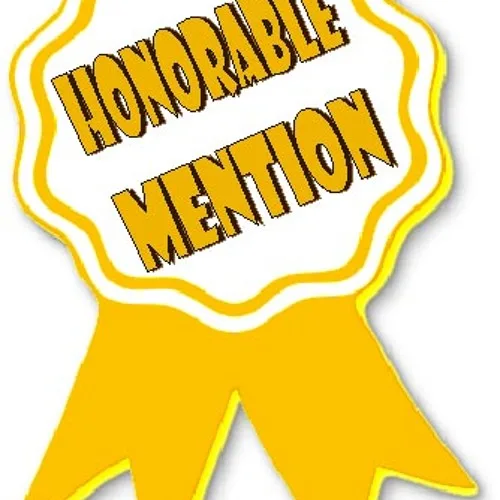

In [7]:
#!!!!
#тут забор
##############################################################################################################################

#######     ####    #    #   #   #   #####     ####        #       #       #   #   #    #   #   #        #
#     #    #    #   #   ##    # #    #        #    #      # #      #       #   #   #   ##   #   #       # #
#     #    #        #  # #     #     ####     #    #     #   #     ####    #####   #  # #   #   #      #####
#     #    #    #   # #  #    # #    #   #    #    #    #     #    #   #   #   #   # #  #   #######   #     #
#     #     ####    #    #   #   #   #####     ####    #       #   #####   #   #   #    #         #  #       #

df['hash_active_count_7dirived'] = df['hash_rate_ma_7']/(df['active_count_ma_7'] *df['volume'])
#эту дичь сделал Макар
df['hash_active_count_dirived14'] = df['hash_active_count_7dirived'].rolling(window=14).mean()

##############################################################################################################################
#тут кончился

## 1.2 Lag features

In [8]:
def create_lag_features(df, columns, n_lags=4):
    df = df.copy()
    for col in columns:
        for lag in range(1, n_lags+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)  # shift(lag) - ПРОШЛЫЕ данные
    return df

In [9]:
df[['date', 'close']]

,date,close
0,2024-01-01,52637.598391
1,2024-01-02,48582.888801
2,2024-01-03,41661.555888
3,2024-01-04,49067.567529
4,2024-01-05,49767.990012
...,...,...
528,2025-07-04,108034.339050
529,2025-07-05,108231.181990
530,2025-07-06,109232.069735
531,2025-07-07,108299.851088


In [10]:
df['price_change'] = (df['close'] > df['close'].shift(1))

features_to_lag = ['close', 'close_change', 'volume','rsi', 'MACD_Cross_Power_Normalized', 'hash-rate',
                   'active-count', 'total_fee', 'transfer_count', 'zew_state', 'zew_mood_index', 'gesi_value'
                   ]
features_to_lag

['close',
 'close_change',
 'volume',
 'rsi',
 'MACD_Cross_Power_Normalized',
 'hash-rate',
 'active-count',
 'total_fee',
 'transfer_count',
 'zew_state',
 'zew_mood_index',
 'gesi_value']

In [11]:
df = create_lag_features(df, features_to_lag)
df.columns

Index(['date', 'close', 'volume', 'rsi', 'MACD_Cross_Power_Normalized',
       'hash-rate', 'active-count', 'total_fee', 'transfer_count',
       'zew_mood_index', 'zew_state', 'active-count_smoothed', 'gesi_value',
       'MACD', 'Signal_Line', 'close_change', 'hash_rate_ma_7', 'close_ma_7',
       'volume_ma_7', 'price_momentum_7d', 'volume_ratio_7d',
       'active_count_ma_7', 'hash_active_count_7dirived', 'returns',
       'volatility_14d', 'rsi_divergence', 'fee_to_volume_ratio',
       'macd_signal_diff', 'zew_mood_ma_3', 'zew_mood_ma_7', 'total_fee_ma_3',
       'total_fee_ma_7', 'total_fee_ma_14', 'hash_active_count_dirived14',
       'price_change', 'close_lag_1', 'close_lag_2', 'close_lag_3',
       'close_lag_4', 'close_change_lag_1', 'close_change_lag_2',
       'close_change_lag_3', 'close_change_lag_4', 'volume_lag_1',
       'volume_lag_2', 'volume_lag_3', 'volume_lag_4', 'rsi_lag_1',
       'rsi_lag_2', 'rsi_lag_3', 'rsi_lag_4',
       'MACD_Cross_Power_Normalized_lag_

In [12]:
df['target_close'] = df['close'].shift(-1)

In [13]:
df[['date', 'close', 'target_close']]

,date,close,target_close
0,2024-01-01,52637.598391,48582.888801
1,2024-01-02,48582.888801,41661.555888
2,2024-01-03,41661.555888,49067.567529
3,2024-01-04,49067.567529,49767.990012
4,2024-01-05,49767.990012,45972.273419
...,...,...,...
528,2025-07-04,108034.339050,108231.181990
529,2025-07-05,108231.181990,109232.069735
530,2025-07-06,109232.069735,108299.851088
531,2025-07-07,108299.851088,108950.275543


In [14]:
df = df.dropna()


In [15]:
selected_features = [
    #'close_lag_4',
    #'zew_mood_index_lag_1', 'zew_mood_index_lag_2', 'zew_mood_index_lag_3',
    #'active-count_lag_1', 'active-count_lag_2',
    #'active-count_lag_3', 'active-count_lag_4', 'active-count_lag_5',
    'hash_active_count_dirived14',
    #'total_fee_lag_1', 'total_fee_lag_2', 'total_fee_lag_3',
    #'transfer_count_lag_1', 'transfer_count_lag_3',
    #'close_change_lag_2', 'close_change_lag_3',
    #'volume_lag_1', 'volume_lag_2', 'volume_lag_3',
    #'hash-rate_lag_1', 'hash-rate_lag_2', 'hash-rate_lag_3',
    'rsi',
    #'MACD',
    'MACD_Cross_Power_Normalized',
    #'rsi_lag_1', 'rsi_lag_2',
    #'MACD_Cross_Power_Normalized_lag_1', 'MACD_Cross_Power_Normalized_lag_2',
    #'rub_usd_lag_1', 'rub_usd_lag_2' , 'rub_usd_lag_3',
    #'gesi_value_lag_1', 'gesi_value_lag_2', 'gesi_value_lag_3',
    'close_ma_7',
    'volume_ma_7',
    #'yuan_lag_1', 'yuan_lag_2', 'yuan_lag_3',
    #'zew_state_lag_1',
    #'zew_mood_ma_3',
    #'zew_mood_ma_7',
    'total_fee_ma_3', #'total_fee_ma_7', 'total_fee_ma_14',
    'hash_active_count_7dirived',
    'price_momentum_7d',
    'volume_ratio_7d',
    #'volatility_14d',
    #'rsi_divergence',
    'fee_to_volume_ratio',
    'macd_signal_diff'
]

## 1.3 Polynomial Features

In [16]:
from sklearn.preprocessing import PolynomialFeatures

In [17]:
PolyTransformer = PolynomialFeatures(degree=3)

### ИМХО, никогда бы этим не занимался

In [18]:
# # Детальная проверка на утечку данных
# print("=== ПРОВЕРКА НА УТЕЧКИ ДАННЫХ ===")

# # 1. Проверка: есть ли в фичах информация из будущего?
# for col in df.columns:
#     # Ищем корреляцию с будущими значениями
#     corr_with_future = df[col].corr(df['close'].shift(-1))
#     if abs(corr_with_future) > 0.8:
#         print(f"⚠️ ВОЗМОЖНА УТЕЧКА: {col} имеет высокую корреляцию с будущей ценой: {corr_with_future:.3f}")

# # 2. Проверка временных меток
# print(f"\nДиапазон дат в фичах: {df['date'].min()} - {df['date'].max()}")
# print(f"Диапазон дат в target: {df[df['target_close'].notna()]['date'].min()} - {df[df['target_close'].notna()]['date'].max()}")

# # 3. Проверка конкретных подозрительных фич
# suspect_features = ['close_ma_7', 'hash_active_count_dirived14', 'hash_active_count_7dirived']
# for feature in suspect_features:
#     if feature in df.columns:
#         # Проверяем, не использует ли фича будущие данные
#         temp_df = df[['date', 'close', feature]].copy()
#         temp_df['future_close'] = temp_df['close'].shift(-1)
#         corr = temp_df[feature].corr(temp_df['future_close'])
#         print(f"Корреляция {feature} с будущей ценой: {corr:.3f}")

In [19]:
# y = df['target_close']

# X = df[selected_features]

In [20]:
X = PolyTransformer.fit_transform(df[selected_features])
y = df['target_close']

In [21]:
df[selected_features].shape

(513, 11)

In [22]:
X.shape

(513, 364)

### 11 ---> 364 Fatures (thanks to Polynomial Features)
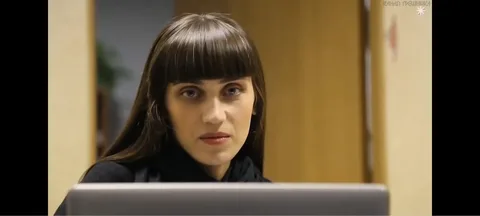

# 2. Learning

## 2.1 Train Test Split via `TimeSeriesSplit`

In [23]:
#теперь разделим на train и test данные

#концепция следующая: на тренировочных данных модель при
# обучении имеет полный доступ к (целевым данным в y) и подстраивает свои
# данные из X(выбранные фичи) под ответы из y - учится, развивается, находит
# закономерности
# а потом на тестовых данных модель будет использовать эти закономерности и пытаться
# угадать ответы из y - при этом здесь уже она не знает данных из y
# "Модель НЕ обучается и НЕ меняется на тестовых данных" - это важно
# ниже я это и сделаю, но при применении кросс-валидации на временных рядах мы к этому
# еще вернемся !!! - там важное уточнение

In [24]:
# Legacy code
train_size = int(len(df) * 0.8)
# X_train = X.iloc[:train_size]
# X_test = X.iloc[train_size:]
# y_train = y.iloc[:train_size]
# y_test = y.iloc[train_size:]

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [25]:
X_train.shape, y_train.shape

((410, 364), (410,))

In [26]:
X_test.shape, y_test.shape

((103, 364), (103,))

In [27]:
test_dates = df.iloc[train_size:]['date']

In [28]:
#далее настройка кросс-валидации для временных рядов - концепция в том, чтобы
#разделить тренировочный промежуток на несколько частей и сначала на первой части
#разделить данные на train и test, а при переходе на вторую часть train2 = train1 + test1
#и так далее
#ВАЖНО! хотя мы тут берем тестовые и тренировочные данные по разному, но тестовые данные, которые
#мы указали выше все равно не будут затронуты в процессе кросс-валидации - и вообще модель
#НИКОГДА не будет на них учиться (в нашем случае - на последних 20% данных)


In [29]:

# tscv = TimeSeriesSplit(
#     n_splits=5,          # у нас будет кроссвалидироваться временной ряд 20 раз (я брал из рассчета 2 раза в год на протяжении 10 лет)
#     test_size=30,        # длина тестового набора - у нас полгода
#     gap=7,               # буфер между train и test, спасает от look-ahead при лагах
# )#еще будем настраивать

In [30]:

tscv = TimeSeriesSplit(
    n_splits=5,          
    test_size=30,        
    gap=7,               
)

## 2.2 Custom metrics and Scoring

In [31]:
def NMAPE(y_true, y_pred):
    return 1 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def directional_accuracy(y_true, y_pred):
    """Точность предсказания направления изменения"""
    true_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    return np.mean(true_direction == pred_direction)


def symmetric_mape(y_true, y_pred):
    """SMAPE метрика (более сбалансированная)"""
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

In [32]:
refit = 'r2'
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mape': make_scorer(NMAPE),
    # 'mse': 'neg_mean_squared_error',                           # adjust to emissions 
    'directional_accuracy': make_scorer(directional_accuracy),
    'symmetric_mape': make_scorer(symmetric_mape),
}

# May be too much

## 2.3 Grid Search for L2

In [33]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),#масштабирование данных - мы приводим цифры к одному масштабу
    ('model', Ridge(random_state=42))
])

In [34]:
ridge_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__random_state': [42]
}

In [35]:

ridge_grid_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=ridge_param_grid,
    cv=tscv,
    scoring=scoring,
    n_jobs=7,
    # verbose=3,
    refit=refit
)

In [36]:
ridge_grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__alpha': [0.001, 0.01, ...], 'model__random_state': [42]}"
,scoring,"{'directional_accuracy': make_scorer(d...hod='predict'), 'mae': 'neg_mean_absolute_error', 'mape': make_scorer(N...hod='predict'), 'r2': 'r2', ...}"
,n_jobs,7
,refit,'r2'
,cv,TimeSeriesSpl... test_size=30)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [37]:
best_ridge = ridge_grid_search.best_estimator_

In [38]:
from joblib import dump, load

In [69]:
dump(best_ridge, 'model__ridge_poly.joblib')

['model__ridge_poly.joblib']

# 3 Evaluating model

## 3.1 Metrics 

In [40]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = NMAPE(y_test, predictions)
    Symmetric_mape = symmetric_mape(y_test, predictions)


    print(f"{model_name}:")
    print(f"symmetric_mape: {Symmetric_mape:.4f}")
    print(f"mape: {mape:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 30)

    return predictions

In [41]:
ridge_pred = evaluate_model(best_ridge, X_test, y_test, "Ridge")

Ridge:
symmetric_mape: 2.6292
mape: -1.6056
MSE: 9967748.8647
R²: 0.9029
------------------------------


## 3.1 Features importance

In [42]:
def get_importance(model, features):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        raise ValueError("Model does not have feature importances.")

    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    return feature_importance


# feature_importanceRidge = pd.DataFrame({
#     'feature': selected_features,
#     'importance': best_ridge.named_steps['model'].coef_ #best_ridge.named_steps['model'].feature_importances_
# }).sort_values('importance', ascending=False)

# print(feature_importanceRidge.head(5))

In [43]:
importance_dict = {best_ridge.steps[1][1].coef_[i] : PolyTransformer.get_feature_names_out()[i] for i in range(len(best_ridge.steps[1][1].coef_))}
importance_dict

{np.float64(0.0): '1',
 np.float64(-508.1344630588785): 'hash_active_count_dirived14',
 np.float64(23.970845885996535): 'rsi',
 np.float64(218.8132388520584): 'MACD_Cross_Power_Normalized',
 np.float64(1565.5161516447292): 'close_ma_7',
 np.float64(378.098966034793): 'volume_ma_7',
 np.float64(-86.86436209701763): 'total_fee_ma_3',
 np.float64(-171.19445872878651): 'hash_active_count_7dirived',
 np.float64(169.17756512448088): 'price_momentum_7d',
 np.float64(-24.172005658082185): 'volume_ratio_7d',
 np.float64(-119.91241390306485): 'fee_to_volume_ratio',
 np.float64(37.62891167006741): 'macd_signal_diff',
 np.float64(-371.36052164963667): 'hash_active_count_dirived14^2',
 np.float64(-383.0003457148028): 'hash_active_count_dirived14 rsi',
 np.float64(177.05269277015535): 'hash_active_count_dirived14 MACD_Cross_Power_Normalized',
 np.float64(686.5468021554688): 'hash_active_count_dirived14 close_ma_7',
 np.float64(24.64683927720353): 'hash_active_count_dirived14 volume_ma_7',
 np.float6

In [44]:
coefs = list(importance_dict.keys())
coefs.sort(key=lambda x: abs(x))

most_important = coefs[-30:]
most_important = most_important[::-1]
most_important

[np.float64(1565.5161516447292),
 np.float64(1396.271160496817),
 np.float64(1265.197766453085),
 np.float64(1226.6938439542052),
 np.float64(1173.4035363485868),
 np.float64(1052.9883435272484),
 np.float64(1019.3563003165588),
 np.float64(978.18191383236),
 np.float64(835.6350858497764),
 np.float64(749.4605477628829),
 np.float64(745.3382254639512),
 np.float64(692.7668474744081),
 np.float64(686.5468021554688),
 np.float64(660.7470274807055),
 np.float64(625.7867226517569),
 np.float64(603.7756007172644),
 np.float64(597.1142439194106),
 np.float64(536.1432672460511),
 np.float64(518.7893585114788),
 np.float64(-508.1344630588785),
 np.float64(472.32076446807105),
 np.float64(439.2936678687916),
 np.float64(-414.3385905916823),
 np.float64(409.207753380376),
 np.float64(402.16282520228964),
 np.float64(-400.36053298141246),
 np.float64(-387.44744154363974),
 np.float64(-383.0003457148028),
 np.float64(378.098966034793),
 np.float64(-371.36052164963667)]

In [45]:
i = 0
for coef in most_important:
    i += 1
    print(f'Feature {i}: Value : {coef.round(2)} ||  Label: {importance_dict[coef]} ')

Feature 1: Value : 1565.52 ||  Label: close_ma_7 
Feature 2: Value : 1396.27 ||  Label: close_ma_7^2 
Feature 3: Value : 1265.2 ||  Label: close_ma_7 hash_active_count_7dirived volume_ratio_7d 
Feature 4: Value : 1226.69 ||  Label: close_ma_7^3 
Feature 5: Value : 1173.4 ||  Label: hash_active_count_dirived14 close_ma_7^2 
Feature 6: Value : 1052.99 ||  Label: close_ma_7^2 hash_active_count_7dirived 
Feature 7: Value : 1019.36 ||  Label: rsi close_ma_7^2 
Feature 8: Value : 978.18 ||  Label: volume_ma_7 hash_active_count_7dirived volume_ratio_7d 
Feature 9: Value : 835.64 ||  Label: rsi close_ma_7 
Feature 10: Value : 749.46 ||  Label: hash_active_count_dirived14 close_ma_7 volume_ma_7 
Feature 11: Value : 745.34 ||  Label: close_ma_7^2 volume_ratio_7d 
Feature 12: Value : 692.77 ||  Label: close_ma_7^2 volume_ma_7 
Feature 13: Value : 686.55 ||  Label: hash_active_count_dirived14 close_ma_7 
Feature 14: Value : 660.75 ||  Label: close_ma_7 volume_ma_7 
Feature 15: Value : 625.79 ||  L

## 3.2 Visualization

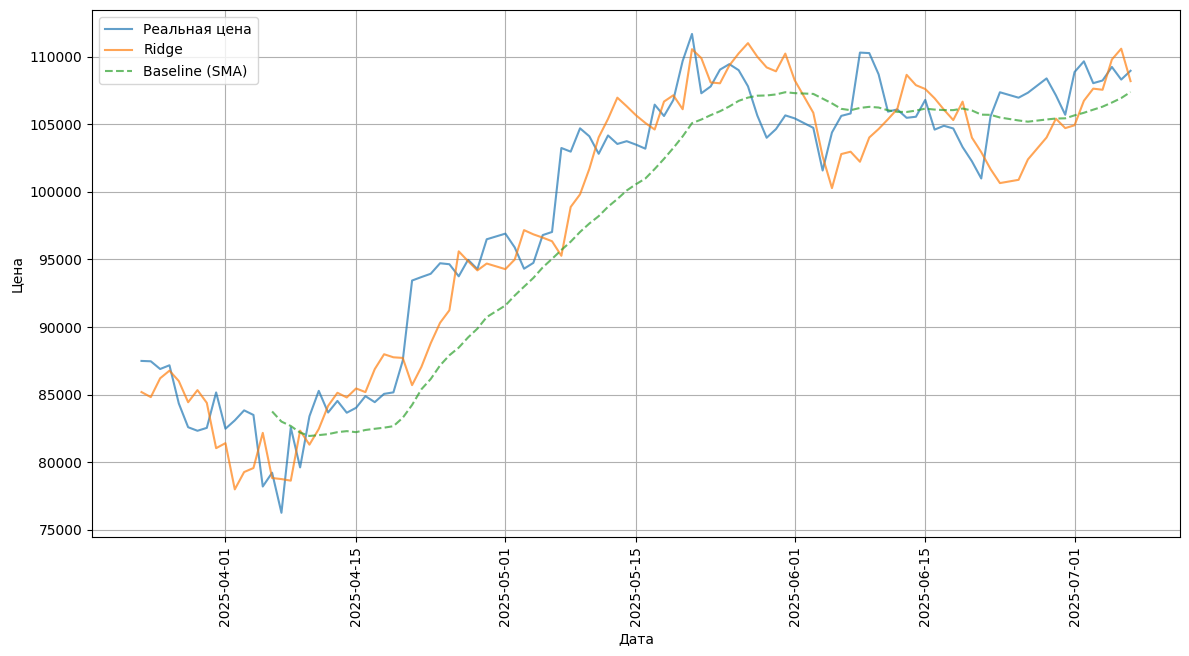

Founded Hyperparams for Ridge: {'model__alpha': 100, 'model__random_state': 42}


In [46]:


#после двух фитов мы получили лучшие модели


#у нас grid_search перебрала все гиперпараметры, нашла лучшие и (потому что refit=True) обучила
# обучила модель на лучших гиперпараметрах и записала ее в свой аттрибут best_estimator_
# вообще говря, мы в отдельную модель записали для удобства, так то она и так хранится в
# gb_grid_search

#супер, у нас есть обученные модели, время проверить их на тестовых данных и вывести результаты


#настал самый волнительный момент в жизни наших моделей - чуваки учились учились и тепрь прогнозируют



#важность фичей для градиентного бустинга




# Добавьте это после создания baseline_pred
# window_size = 20  # Размер окна сглаживания
# sma_baseline = y_test.rolling(window=window_size).mean().dropna()

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
window_size = 15
sma_baseline = y_test.rolling(window=window_size).mean()
aligned_test_dates = test_dates[:len(sma_baseline)]

# Проверяем, чтобы не было NaN
sma_values = sma_baseline.dropna()
aligned_test_dates = aligned_test_dates[len(sma_baseline) - len(sma_values):]

plt.plot(test_dates,y_test.values, label='Реальная цена', alpha=0.7)
# plt.plot(rf_pred, label='Random Forest', alpha=0.7)
#plt.plot(test_dates,gb_pred, label='Gradient Boosting', alpha=0.7)
plt.plot(test_dates,ridge_pred, label='Ridge', alpha=0.7)
#plt.plot(test_dates[:len(sma_baseline)],sma_baseline.values, label='Baseline', alpha=0.7)
plt.plot(aligned_test_dates, sma_values.values, label='Baseline (SMA)', alpha=0.7, linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('predictions_V2.png')
plt.xticks(rotation=90)
plt.show()

print("Founded Hyperparams for Ridge:", ridge_grid_search.best_params_)

## 3.3 Adding Shift.
This can be analysed, beacuse we can see some pattern. Prediction of our's model can be some kind of **momentum** of the price. It describes movement of pricce in next days, while it predicts only one next day 

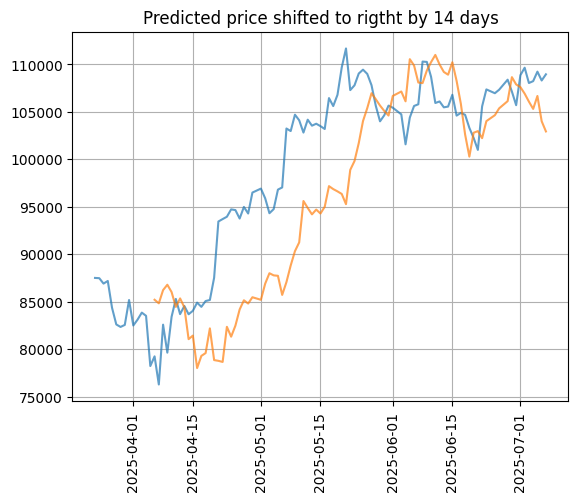

In [67]:
k = 14

shiftedK       = ridge_pred[k:]
shifted_true_K = y_test[:-k] 


plt.title('Predicted price shifted to rigtht by 14 days')
plt.plot(test_dates,y_test.values, label='Реальная цена', alpha=0.7)
# plt.plot(rf_pred, label='Random Forest', alpha=0.7)
#plt.plot(test_dates,gb_pred, label='Gradient Boosting', alpha=0.7)
plt.plot(test_dates[k:],ridge_pred[:-k], label='Ridge', alpha=0.7);
plt.xticks(rotation=90)
plt.grid()

In [68]:
for k in range(1, 15):
    shiftedK       = ridge_pred[k:]
    shifted_true_K = y_test[:-k] 
    print(f'Shift = {k}, R^2 = {r2_score(shifted_true_K, shiftedK)} | MAPE = {-NMAPE(shifted_true_K, shiftedK)}')

Shift = 1, R^2 = 0.9347465250858852 | MAPE = 1.1355465195971686
Shift = 2, R^2 = 0.9377258553232615 | MAPE = 1.0824707861731326
Shift = 3, R^2 = 0.9402514817146235 | MAPE = 1.0922103119634379
Shift = 4, R^2 = 0.935139169314949 | MAPE = 1.2452278700902921
Shift = 5, R^2 = 0.9150636643799885 | MAPE = 1.5524000130666775
Shift = 6, R^2 = 0.8776771062107732 | MAPE = 2.0578486008090473
Shift = 7, R^2 = 0.8370758418942383 | MAPE = 2.5144557413527093
Shift = 8, R^2 = 0.7942258683844996 | MAPE = 2.946396911452076
Shift = 9, R^2 = 0.7559576102010148 | MAPE = 3.334995908149849
Shift = 10, R^2 = 0.7157100642289344 | MAPE = 3.709492186556628
Shift = 11, R^2 = 0.6789115915715671 | MAPE = 4.119230985857857
Shift = 12, R^2 = 0.6331991933398542 | MAPE = 4.514331808646379
Shift = 13, R^2 = 0.5828634444742682 | MAPE = 4.90260119204225
Shift = 14, R^2 = 0.5383007135043436 | MAPE = 5.3086601140689815


# Conclusion

We can see that metrics are getting worse with shifting, but for human-eyed analysis this predictions shows tendency of price movement  